# Regularization - Lasso and Ridge

Understand the principles behind ridge and lasso regression. Goals:

1) state the purpose of regularization techniques in general

2) identify the advantages of ridge and lasso over ordinary least squares

3) state scenarios in which you might prefer ridge over lasso and vice-versa

4) run these techniques on an example dataset

### Step 1: Set up simple Linear Regression

For the test data, create some points from a sine curve from 20 degrees to 320, and plot them for verification.

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

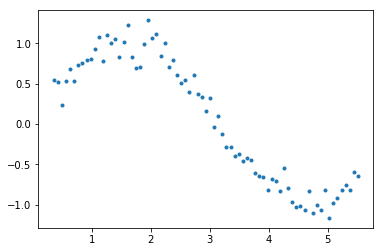

In [2]:
#Define input array with angles from 20deg to 320deg converted to radians
x = np.array([i*np.pi/180 for i in range(20,320,4)])
np.random.seed(10)  #Setting seed for reproducability
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])

plt.plot(data['x'],data['y'],'.')

Create dummy imput variables by using powers of x: x^2, x^3, etc for multivariate fit.

In [3]:
for i in range(2,16):  #Power of 1 is already there
    colname = 'x_%d'%i      #New var will be x_power
    data[colname] = data['x']**i
    
print(data.head())

          x         y       x_2       x_3       x_4       x_5       x_6  \
0  0.349066  0.541758  0.121847  0.042533  0.014847  0.005182  0.001809   
1  0.418879  0.514028  0.175460  0.073496  0.030786  0.012896  0.005402   
2  0.488692  0.237662  0.238820  0.116709  0.057035  0.027873  0.013621   
3  0.558505  0.528662  0.311928  0.174214  0.097299  0.054342  0.030350   
4  0.628319  0.680986  0.394784  0.248050  0.155855  0.097926  0.061529   

        x_7       x_8       x_9      x_10      x_11      x_12      x_13  \
0  0.000631  0.000220  0.000077  0.000027  0.000009  0.000003  0.000001   
1  0.002263  0.000948  0.000397  0.000166  0.000070  0.000029  0.000012   
2  0.006657  0.003253  0.001590  0.000777  0.000380  0.000186  0.000091   
3  0.016951  0.009467  0.005287  0.002953  0.001649  0.000921  0.000514   
4  0.038660  0.024291  0.015262  0.009590  0.006025  0.003786  0.002379   

           x_14          x_15  
0  3.987522e-07  1.391908e-07  
1  5.119653e-06  2.144515e-06  
2 

Fit OLS for the variables.
Note: Number of variables is equal to the power input earlier

In [4]:
#Import Linear Regression model from scikit-learn
from sklearn.linear_model import LinearRegression

#Perform linear regresson on the variables
def linear_regression(data, power, models_to_plot):
    #Initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

Next, fit the data onto the model, and plot a few of them for increasing number of variables.

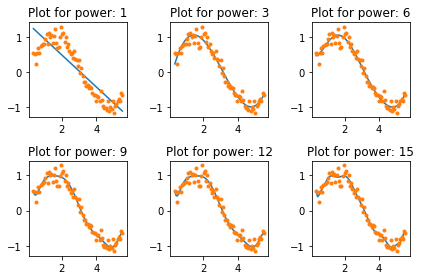

In [5]:
#Initialize a dataframe to store the results
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

The model is overfitting. Next, exxamine the coefficients.

In [6]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,9.3,1.4,-0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,8.1,1,-0.091,-0.062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.4,-0.46,2.3,-1,0.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.3,-0.23,1.8,-0.65,0.013,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1.2,0.19,0.41,0.7,-0.56,0.12,-0.0073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,1.2,0.65,-1.4,3.1,-2,0.56,-0.073,0.0037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,1.2,0.18,0.84,-0.66,1,-0.76,0.24,-0.034,0.0018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,1.2,0.42,-0.49,2.1,-1.7,0.82,-0.28,0.066,-0.0085,0.00044,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,1.1,3.7,-21,52,-63,45,-19,5.2,-0.84,0.075,-0.0028,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,1.1,5,-30,76,-98,75,-36,11,-2.1,0.26,-0.017,0.00049,NaN,NaN,NaN,NaN,NaN


All coefficients seem to increase as with addition of more variables, when there is no "real" reason for them to do so. To combat this effect, use either Ridge or Lasso regression:

### Section 2: Ridge Regression

Define a function similar to the naive OLS fit but using sklearn.linear_model.Ridge

In [7]:
#Import Ridge Regression model from scikit-learn.
from sklearn.linear_model import Ridge

#Perform ridge regresson on the variables
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

Run a test similar to that in step 1, but keeping all 15 variables (powers) and instead varying our lambda value

C:\Users\prani\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.074822e-17
  overwrite_a=True).T


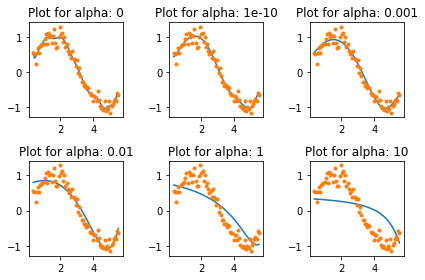

In [8]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [0, 1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {0:231, 1e-10:232, 1e-3:233, 1e-2:234, 1:235, 10:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

Investigating how the coefficients change with varying values of alpha

In [9]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_0,1,42,-4.3e+02,1.9e+03,-5e+03,8.5e+03,-9.8e+03,8.2e+03,-4.9e+03,2.2e+03,-7.3e+02,1.8e+02,-32,4,-0.33,0.017,-0.00038
alpha_1e-15,1.1,5.4,-33,84,-1.1e+02,80,-35,7.9,-0.32,-0.27,0.047,0.0043,-0.0016,-5.1e-05,5.8e-05,-7.3e-06,3e-07
alpha_1e-10,1.1,0.63,-1.8,4.9,-4.4,1.9,-0.36,-0.014,0.0097,0.00089,-0.00019,-4.7e-05,-5.1e-07,1.3e-06,1.5e-07,-3.1e-08,2.9e-10
alpha_1e-08,1.1,0.14,0.82,-0.14,0.055,-0.035,-0.011,0.002,0.00078,5.8e-05,-1.7e-05,-6e-06,-7.3e-07,5.5e-08,4.2e-08,6.6e-09,-1.4e-09
alpha_0.0001,1.3,0.0057,1.2,-0.3,-0.04,-0.00014,0.00085,0.00019,2.7e-05,1.9e-06,-1.9e-07,-1.1e-07,-2.4e-08,-3.9e-09,-3.6e-10,3.9e-11,3.2e-11
alpha_0.001,1.6,0.31,0.74,-0.18,-0.027,-0.0015,0.0002,7.9e-05,1.5e-05,2.3e-06,2.5e-07,1.6e-08,-1.6e-09,-8.5e-10,-2e-10,-3.2e-11,-3.2e-12
alpha_0.01,3,0.74,0.2,-0.072,-0.013,-0.0015,-8.1e-05,1.2e-05,5.1e-06,1.2e-06,2.2e-07,3.4e-08,4.6e-09,4.4e-10,-2e-12,-1.6e-11,-6e-12
alpha_1,9.6,0.76,-0.1,-0.016,-0.0025,-0.00038,-5.3e-05,-6.9e-06,-8.2e-07,-7.7e-08,-2.6e-09,1.4e-09,5.4e-10,1.5e-10,3.4e-11,7.4e-12,1.5e-12
alpha_5,20,0.45,-0.044,-0.007,-0.0012,-0.00018,-2.9e-05,-4.5e-06,-7e-07,-1.1e-07,-1.6e-08,-2.3e-09,-3.2e-10,-4.3e-11,-5.2e-12,-5.3e-13,-2.6e-14
alpha_10,24,0.34,-0.028,-0.0045,-0.00076,-0.00013,-2.1e-05,-3.4e-06,-5.6e-07,-9.1e-08,-1.5e-08,-2.4e-09,-3.9e-10,-6.3e-11,-1e-11,-1.6e-12,-2.6e-13


Check if any of the coefficients are 0

In [10]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

alpha_0         0
alpha_1e-15     0
alpha_1e-10     0
alpha_1e-08     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_1         0
alpha_5         0
alpha_10        0
dtype: int64

### Section 3: Lasso (Least Absolute Shrinkage and Selection Operator)

Define a function for performing lasso regression

In [11]:
#Import Lasso Regression model from scikit-learn.
from sklearn.linear_model import Lasso

#Perform lasso regresson on the variables
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

Plot different values of alpha

C:\Users\prani\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\prani\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\prani\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


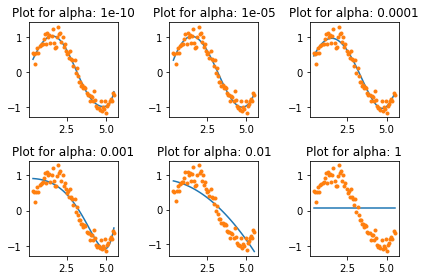

In [12]:
#Initialize predictors to all 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

#Initialize the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 alpha values
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

The model underfits the data when alpha = 1. Check for variables with coefficient equal to 0.

In [13]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,1.2,0.0062,1.1,-0.07,-0.14,0.0058,0.0027,0.00032,8.4e-06,-4.5e-06,-1.2e-06,-1.8e-07,-1.7e-08,-1.3e-10,3.6e-10,9.3e-11,1.3e-11
alpha_1e-10,1.2,0.0062,1.1,-0.07,-0.14,0.0058,0.0027,0.00032,8.4e-06,-4.5e-06,-1.2e-06,-1.8e-07,-1.7e-08,-1.3e-10,3.6e-10,9.3e-11,1.3e-11
alpha_1e-08,1.2,0.0062,1.1,-0.07,-0.14,0.0058,0.0028,0.00032,8.3e-06,-4.4e-06,-1.2e-06,-1.8e-07,-1.7e-08,-1.2e-10,3.5e-10,9.4e-11,1.3e-11
alpha_1e-05,1.3,-0.13,1.5,-0.49,-0.0074,0,0.0012,0.00014,0,-0,-0,-6.3e-08,-2e-08,-0,-0,0,1.3e-11
alpha_0.0001,1.4,0.1,1.2,-0.39,-0,0,0,0.00019,0,0,0,0,-0,-0,-0,-0,-5.5e-12
alpha_0.001,3.9,0.91,0,-0.031,-0.016,-0,-0,0,0,0,0,6.2e-08,4.7e-09,0,0,0,0
alpha_0.01,8.7,0.86,-0.063,-0.057,-0,-0,-0,0,0,0,0,0,0,0,0,0,0
alpha_1,45,0.059,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,45,0.059,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_10,45,0.059,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


In [14]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      7
alpha_0.0001    11
alpha_0.001     11
alpha_0.01      13
alpha_1         15
alpha_5         15
alpha_10        15
dtype: int64

### Step 4: OLS vs Ridge vs Lasso!

Load 'Auto.csv' to compare OLS, Ridge and LASSO for predicting MPG in germs of the other variables in the dataset and compare the coefficients by varying alpha value.

In [15]:
auto_data = pd.read_csv("./data/Auto.csv")
auto_data = auto_data[auto_data.horsepower != '?'] #Get rid of "?" values

response = "mpg" #Identifies which variable we want to try to predict
#Predict based on all values other than name, since it is non-numeric

predictors = ['cylinders','displacement','horsepower','weight','acceleration','year','origin']

auto_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18,8,3.1e+02,130,3504,12,70,1,chevrolet chevelle malibu
1,15,8,3.5e+02,165,3693,12,70,1,buick skylark 320
2,18,8,3.2e+02,150,3436,11,70,1,plymouth satellite
3,16,8,3e+02,150,3433,12,70,1,amc rebel sst
4,17,8,3e+02,140,3449,10,70,1,ford torino


In [16]:
#Run OLS linear regression
def ols_linear_regression(data, predictors):
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors], data[response])
    y_pred = linreg.predict(data[predictors])
    
    #Return the result in pre-defined format
    rss = sum((y_pred - data[response]) **2)    
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

coef_ols = ols_linear_regression(auto_data, predictors)

In [17]:
#Run Ridge regression
def ridge_regression(data, predictors, alpha):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors], data[response])
    y_pred = ridgereg.predict(data[predictors])
    
    #Return the result in pre-defined format
    rss = sum((y_pred- data[response]) **2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

col = ['rss','intercept'] + ['coef_%s'%i for i in auto_data.columns[1: -1]]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,11)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

alpha_ridge = [0, 1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
              
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(auto_data, predictors, alpha_ridge[i])

In [18]:
#Run Lasso regression
def lasso_regression(data, predictors, alpha):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors], data[response])
    y_pred = lassoreg.predict(data[predictors])
    
    #Return the result in pre-defined format
    rss = sum((y_pred- data[response]) **2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 0.005]

col = ['rss','intercept'] + ['coef_%s'%i for i in auto_data.columns[1:-1]]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(auto_data, predictors, alpha_lasso[i])

In [19]:
#Show linear coefficients
coef_ols

[4252.212530440172,
 -17.218434622017593,
 -0.4933763188584747,
 0.019895643742016557,
 -0.01695114422749929,
 -0.006474043397440459,
 0.08057583832486247,
 0.7507726779503122,
 1.4261404954231498]

In [20]:
#Show ridge coefficients
pd.options.display.float_format = '{:,.9g}'.format
coef_matrix_ridge

,rss,intercept,coef_cylinders,coef_displacement,coef_horsepower,coef_weight,coef_acceleration,coef_year,coef_origin
alpha_0,"4,252.21253",-17.2184346,-0.493376319,0.0198956437,-0.0169511442,-0.0064740434,0.0805758383,0.750772678,1.4261405
alpha_1e-15,"4,252.21253",-17.2184346,-0.493376319,0.0198956437,-0.0169511442,-0.0064740434,0.0805758383,0.750772678,1.4261405
alpha_1e-10,"4,252.21253",-17.2184346,-0.493376317,0.0198956437,-0.0169511443,-0.00647404339,0.0805758378,0.750772678,1.42614049
alpha_1e-08,"4,252.21253",-17.2184334,-0.49337618,0.0198956349,-0.0169511471,-0.00647404258,0.0805757862,0.750772659,1.42614044
alpha_0.0001,"4,252.21493",-17.2066373,-0.49199022,0.01980716,-0.0169800454,-0.00646588063,0.0800554466,0.75058258,1.42554772
alpha_0.001,"4,252.4426",-17.1012274,-0.480068225,0.0190329386,-0.0172387896,-0.00639382512,0.0754733203,0.748893969,1.42038658
alpha_0.01,"4,268.23487",-16.1243388,-0.401493647,0.0129879448,-0.01962578,-0.00578796627,0.0380421641,0.733844439,1.38165221
alpha_1,"5,947.10046",4.96708147,-0.569293656,-0.00955354465,-0.0267215579,-0.00165212668,0.0724485475,0.373902479,1.03222058
alpha_5,"10,841.5652",16.4815355,-0.361494645,-0.00610059879,-0.0161491624,-0.000832559443,0.100072927,0.155608731,0.581177456
alpha_10,"14,435.5369",19.3913198,-0.240581973,-0.00406051991,-0.0107051401,-0.000535648035,0.0733797191,0.0939199961,0.378893746


In [21]:
#Show lasso coefficients
coef_matrix_lasso

,rss,intercept,coef_cylinders,coef_displacement,coef_horsepower,coef_weight,coef_acceleration,coef_year,coef_origin
alpha_1e-15,"4,252.21253",-17.2184346,-0.493376319,0.0198956437,-0.0169511442,-0.0064740434,0.0805758383,0.750772678,1.4261405
alpha_1e-10,"4,252.21253",-17.2184346,-0.493376294,0.0198956429,-0.0169511438,-0.00647404337,0.0805758365,0.750772677,1.42614048
alpha_1e-08,"4,252.21253",-17.2184338,-0.493373849,0.0198955565,-0.0169511036,-0.00647404021,0.0805756431,0.750772596,1.42613932
alpha_1e-05,"4,252.21403",-17.2176679,-0.490905424,0.0198091786,-0.0169111242,-0.00647090774,0.080382248,0.750691614,1.42498156
alpha_0.0001,"4,252.36228",-17.2095657,-0.469247149,0.0190319762,-0.0165453583,-0.00644203496,0.0786230187,0.749957351,1.41447101
alpha_0.001,"4,266.91131",-17.1381333,-0.253338495,0.0113391412,-0.012890727,-0.00615968553,0.0614919551,0.742724181,1.3104479
alpha_0.01,"4,361.37371",-13.8916863,-0,-0,-0.00934426066,-0.00553825817,0,0.699938257,1.02972988
alpha_1,"23,818.9935",23.4459184,-0,-0,-0,-0,0,0,0
alpha_5,"23,818.9935",23.4459184,-0,-0,-0,-0,0,0,0
alpha_0.005,"4,339.44946",-15.5988805,-0,-0,-0.00886050069,-0.00558888919,0.0114464333,0.719776329,1.10726271


### Step 5: Reflection

#### Comparing the three methods to the best fit for the data you investigated (OLS, Ridge, Lasso)?

The predictors that Lasso selected for alpha value as 0.005 are horsepower, weight, acceleration, year and origin. Personally, I thought that year and origin wouldn't have played a significant role in predicting mpg value. However, lasso considered them to have significant impact on our response variable.

The first thing that is noticable is that with alpha value as 0 in lasso regression and ridge regression, the values of coeffients are same (most likely similar) to that of linear regression. As we see from the coefficient matrix in lasso regression, with increasing values of alpha, the coefficient values are approaching zero.
The next thing that I noticed is that the minimum error in ols, ridge and lasso are same i.e 
error of ols: 4252.212530440172
error of ridge: 4,252.21253
error of lasso: 4,252.21253
Since the error terms are nearly same, the one thing that can be deduced is that the dataset doesn't have normalized data i.e. they have different scales. So, there is a problem of multicollinearity in our results.
There are multiple possibilities to interpret the results:
When the predictor variables are not in the similar scales,
a. if the 2 correlated variables are both considered in the model, the collinearity is not a problem;
b. if only one of the two correlated variables is in the model, the following things need to be considered:
b.1. If the other "true" variables are included in the regression, the regression will identify the non-significant variables that are correlated with the significant variable.
b.2 If the other "true" variables are not included in the regression, collinearity can become an issue which might result in increase in standard error.
I believe that further analysis on the dataset (EDA) is required to determine the issue of collinearity to rightly interpret our results. Although thoeretically, ridge might perform better if there are relation between predictors. On the other hand, lasso regression performs better if there are variable with missing data.